In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from plotnine import *
from datetime import datetime
import pytz

%matplotlib inline

In [2]:
memory_free = pd.read_parquet("path/to/node_memory_MemFree/")
memory_free = memory_free / (1024 * 1024 * 1024)

In [3]:
memory_total = pd.read_parquet("path/to/node_memory_MemTotal/")
memory_total = memory_total / (1024 * 1024 * 1024)

In [21]:
for c in memory_total.columns:
    if memory_total[c].max() >= 257:
        print(c)

r23n23
r23n26


In [4]:
mem_used_df = pd.read_parquet("path/to/node_memory_MemTotal%20-%20node_memory_MemFree%20-%20node_memory_Buffers%20-%20node_memory_Cached%20-%20node_memory_Slab%20-%20node_memory_PageTables%20-%20node_memory_SwapCached/")
mem_used_df = mem_used_df / (1024 * 1024 * 1024)
print(mem_used_df.values.max())

nan


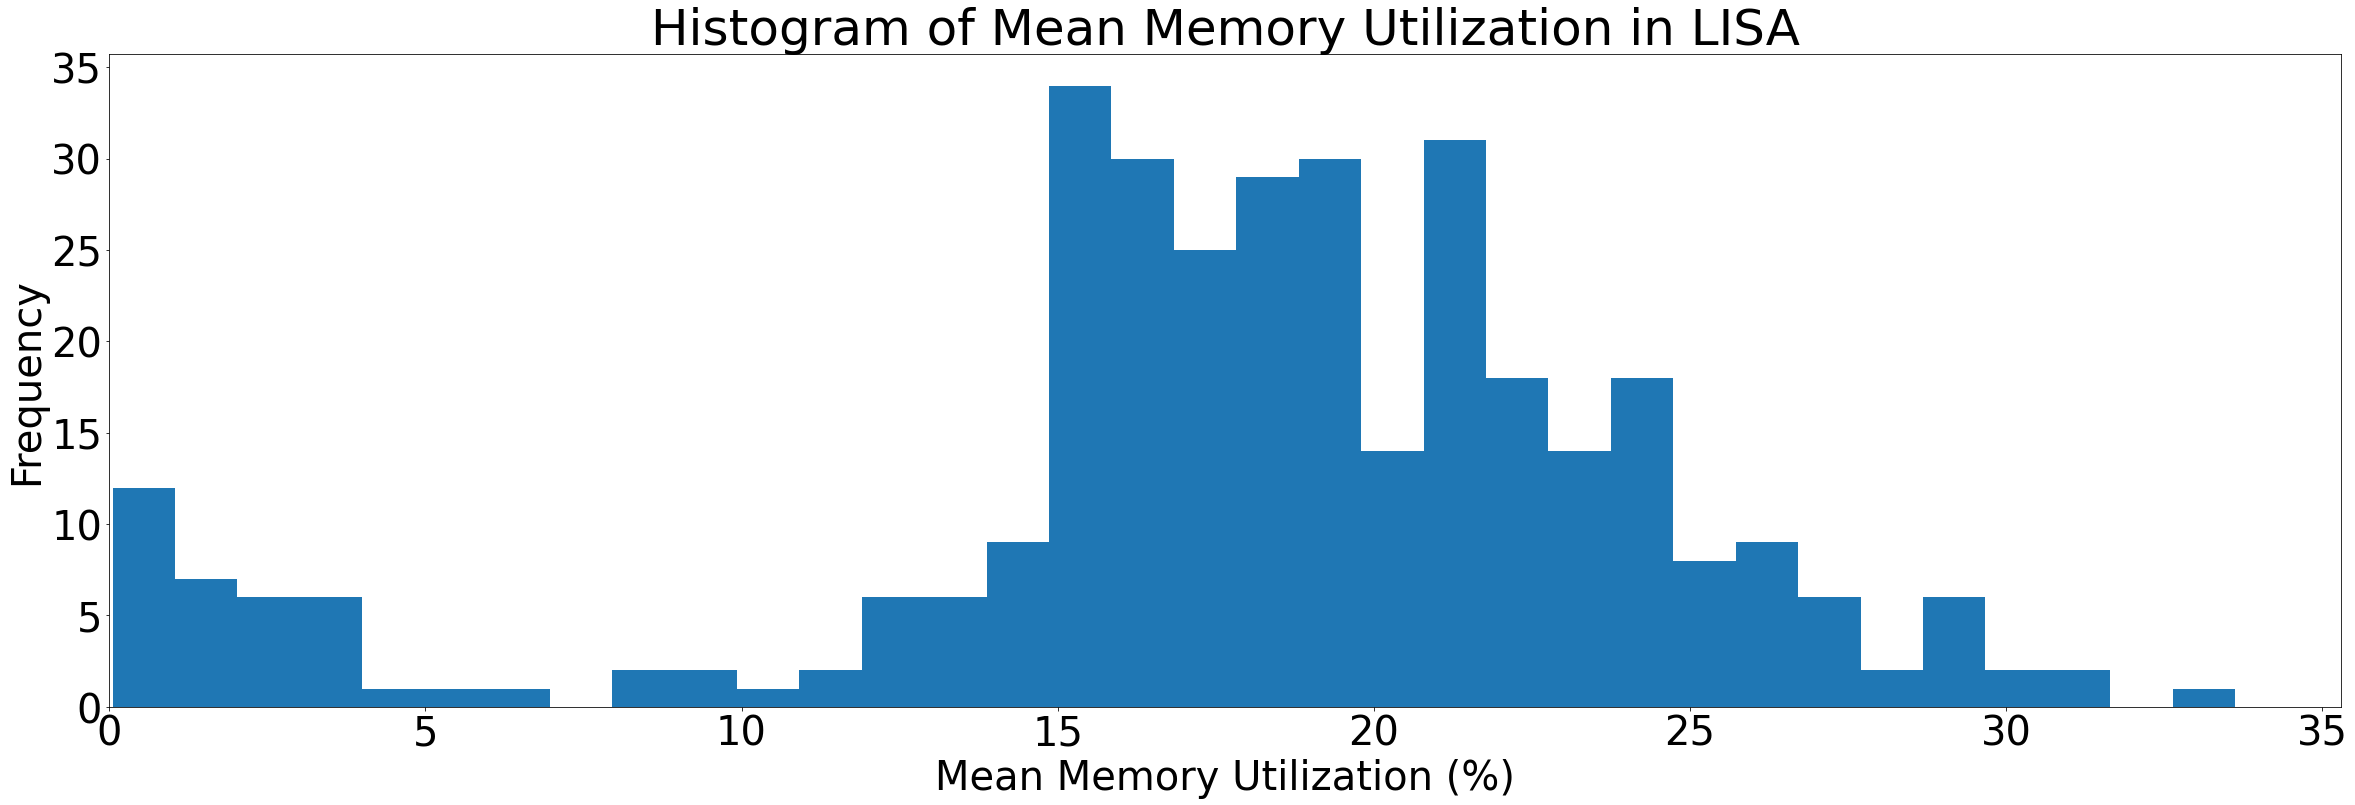

In [9]:
mean_memory_per_node = mem_used_df.mean() * 100

fig = plt.figure(figsize=(40,12))
ax = mean_memory_per_node.plot.hist(bins=math.ceil(mean_memory_per_node.max()))
ax.set_xlim(0,)
ax.set_xlabel("Mean Memory Utilization (%)", fontsize=40)
ax.set_ylabel("Frequency", fontsize=40)
ax.tick_params(axis='both', which='major', labelsize=40)
ax.tick_params(axis='both', which='minor', labelsize=32)
ax.set_title("Histogram of Mean Memory Utilization in LISA", fontsize=50)
plt.savefig("mean_memory_utilization_percentage.pdf")

In [21]:
def normalize(df):
    df = df.value_counts(sort=False, normalize=True).rename_axis('target').reset_index(name='pdf')
    df["cdf"] = df["pdf"].cumsum()
    return df

all_values_df = pd.DataFrame({"target": mem_used_df.values.ravel()})
count_df = normalize(all_values_df)
del all_values_df


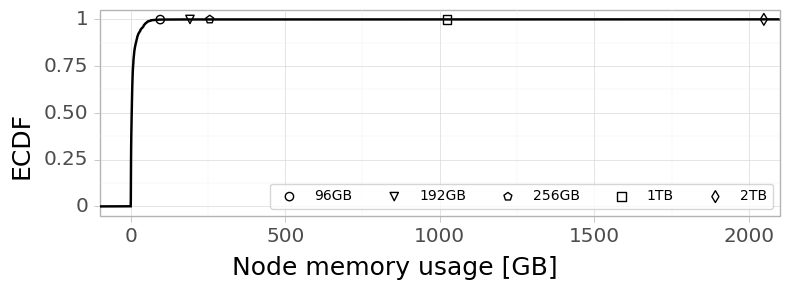

In [22]:
# Add a row at the start so that the CDF starts at 0 and ends at 1 (in case we only have one datapoint in the DF)
plot_df = count_df.copy()
plot_df.index = plot_df.index + 1  # shifting index
plot_df.reset_index(inplace=True)
plot_df['index'] = plot_df['index'] + 1
plot_df.loc[0] = [0, -math.inf, 0, 0]  # add a row  at the start (index, count, pdf, cdf)
plot_df.loc[len(plot_df)] = [len(plot_df), math.inf, 1, 1]
plot_df.sort_index(inplace=True)

ggplt = ggplot(plot_df) + \
            theme_light(base_size=18) + \
            theme(figure_size = (8,3)) + \
            geom_step(aes(x="target", y="cdf"), size=1) +\
            xlab("Node memory usage [GB]") + \
            ylab("ECDF")


marker_x = [96, 192, 256, 1024, 2048]
marker_y = []
for i in marker_x:
    marker_y.append(count_df[count_df['target'].le(i) | np.isclose(count_df['target'], i, rtol=1e-10, atol=1e-12)].tail(1)['cdf'].iloc[0])


marker_labels = ["96GB", "192GB", "256GB", "1TB", "2TB"]
markers = ['o', 'v', 'p', 's', 'd']

fig = ggplt.draw(return_ggplot=False)
ax = plt.gca()
for x_pos, y_pos, marker_symbol, marker_label in zip(marker_x, marker_y, markers, marker_labels):
    ax.scatter(x_pos, y_pos, marker=marker_symbol, label=marker_label, facecolors="None", edgecolors="black")
ax.legend(ncol=len(marker_x), loc=4, prop={'size': 10})

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")

fig.tight_layout()
fig.savefig("memory_usage_cdf_nodes_{}.pdf".format(date_time))


In [14]:
t = '''\\begin{{table}}[]
\\caption{{RAM usage (GB) per percentage within Lisa.}}
\\label{{surfing:tbl:ram-usage-percentiles}}
\\begin{{tabular}}{{@{{}}lrrrrrrr@{{}}}}
\\toprule
    & 1\\% & 25\\% & 50\\% & 75\\% & 90\\% & 99\\% & 100\\% \\\\ \\midrule
RAM & {0}    & {1}     & {2}     & {3}     & {4}     & {5}    & {6} \\\\ \\bottomrule
\\end{{tabular}}
\\end{{table}}'''

percentages = [0.01, 0.25, 0.50, 0.75, 0.90, 0.99, 1]
values = []

for p in percentages:
    values.append(count_df[count_df['cdf'].ge(p) | np.isclose(count_df['cdf'], p, rtol=1e-8, atol=1e-12)].iloc[0]['target'])

print(t.format(*["{:.2f}".format(v) for v in values]))

\begin{table}[]
\caption{RAM usage (GB) per percentage within Lisa.}
\label{surfing:tbl:ram-usage-percentiles}
\begin{tabular}{@{}lrrrrrrr@{}}
\toprule
    & 1\% & 25\% & 50\% & 75\% & 90\% & 99\% & 100\% \\ \midrule
RAM & 0.64    & 1.46     & 3.65     & 8.07     & 20.99     & 58.06    & 2000.22 \\ \bottomrule
\end{tabular}
\end{table}


In [6]:
t = '''\\begin{{table}}[]
\\caption{{Fraction of RAM usage below or at specified level.}}
\\label{{surfing:tbl:ram-usage-fraction}}
\\begin{{tabular}}{{@{{}}lrrrrrr@{{}}}}
\\toprule
    & 96GB & 192GB & 256GB & 1TB & 2TB \\\\ \\midrule
Percentage & {0}    & {1}     & {2}     & {3}     & {4}    \\\\ \\bottomrule
\\end{{tabular}}
\\end{{table}}'''

RAMs = [96, 192, 256, 1024, 2048]
values = []

for r in RAMs:
    values.append(count_df[count_df['target'].le(r) | np.isclose(count_df['target'], r, rtol=1e-10, atol=1e-12)].tail(1)['cdf'].iloc[0])

print(t.format(*["{:.2f}".format(v) for v in values]))

\begin{table}[]
\caption{Fraction of RAM usage below or at specified level.}
\label{surfing:tbl:ram-usage-fraction}
\begin{tabular}{@{}lrrrrr@{}}
\toprule
    & 96 & 192 & 256 & & 1024 & 2048 \\ \midrule
Percentage & 1.00    & 1.00     & 1.00     & 1.00     & 1.00    \\ \bottomrule
\end{tabular}
\end{table}


In [5]:
# This cell outputs the special node 1128 in rack 1128, the 2TB RAM node
# Unobfuscated it is r23n23
memory_free_1128 = memory_free['r23n23']
memory_total_1128 = memory_total['r23n23']

df_1128 =  memory_free_1128.to_frame(name = 'free').join(memory_total_1128.to_frame(name='total')).replace(-1, np.NaN)

df_1128['util'] = 1 - (df_1128['free'] / df_1128['total'])
df_1128["dt"] = pd.to_datetime(df_1128.index, utc=True, unit="s")
df_1128["dt"] = df_1128["dt"].dt.tz_convert(pytz.timezone('Europe/Amsterdam')).dt.tz_localize(None)
df_1128 = df_1128.set_index("dt")

In [14]:
df_1128['util']

dt
2019-12-30 07:00:15    0.052183
2019-12-30 07:00:30    0.052183
2019-12-30 07:00:45    0.052180
2019-12-30 07:01:00    0.052180
2019-12-30 07:01:15    0.052179
                         ...   
2020-05-19 23:58:45    0.000968
2020-05-19 23:59:00    0.000968
2020-05-19 23:59:15    0.000968
2020-05-19 23:59:30    0.000968
2020-05-19 23:59:45    0.000968
Name: util, Length: 805199, dtype: float64

0.2740170263408781 15.536085501122136


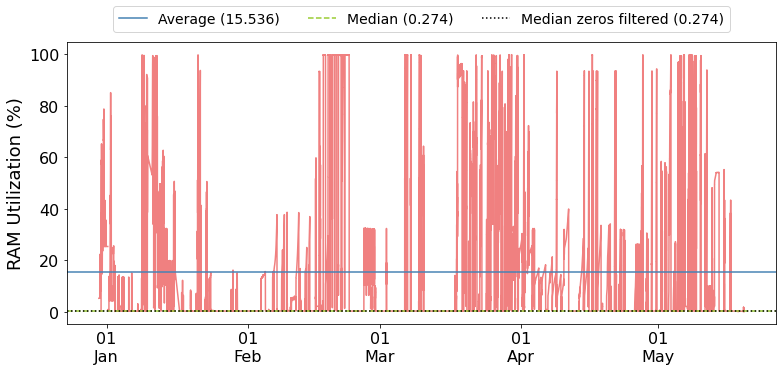

In [19]:
def get_converted_xticks(ax):
    """
    :param ax:
    :return list of day and month strings
    """
    return [pd.to_datetime(tick.get_text()).date().strftime("%d\n%b") for tick in ax.get_xticklabels()]

median = df_1128['util'].median() * 100
median_zeroes_filtered = df_1128['util'][df_1128['util'] > 0].median() * 100
avg = df_1128['util'].mean() * 100

print(median, avg)
# print(df_1128['util'])

fig, ax = plt.subplots(figsize=(11, 5))
ax.plot(df_1128['util'] * 100, color="lightcoral")
ax.set_ylabel("RAM Utilization (%)", fontsize=18)
ax.set_xlabel("", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

ax.axhline(avg, label="Average ({:.3f})".format(avg), color="steelblue", linestyle="solid")
ax.axhline(median, label="Median ({:.3f})".format(median), color="yellowgreen", linestyle="dashed")
ax.axhline(median_zeroes_filtered, label="Median zeros filtered ({:.3f})".format(median_zeroes_filtered), color="black", linestyle="dotted")

ax.legend(ncol=3, prop={"size": 14}, bbox_to_anchor=(0.5, 1.15), loc=9)

fig.tight_layout()
# This call needs to be after the tight_layout call so that the labels have been set!
ax.set_xticklabels(get_converted_xticks(ax))

date_time = datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
fig.savefig("ram_utilization_node1128_{}.pdf".format(date_time), bbox_inches='tight')